### Loading the color-temperature-precipitaion scale images

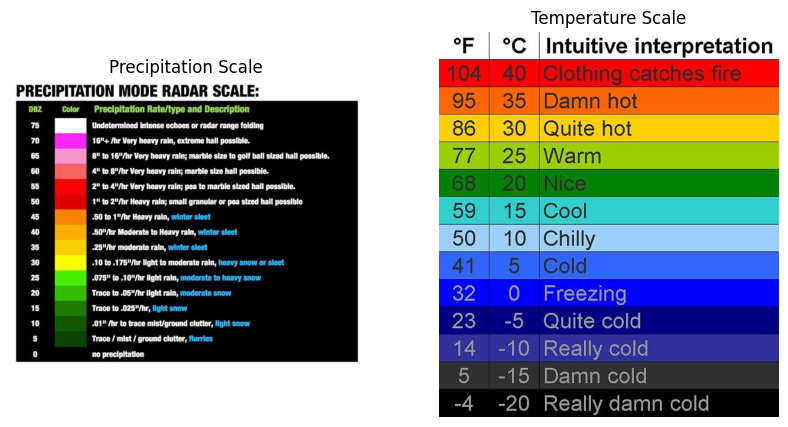

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read images
precipitation_image = cv2.imread('scale.jpg')
temperature_image = cv2.imread('temp.jpg')

# Plot the images for reference
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(precipitation_image, cv2.COLOR_BGR2RGB))
plt.title('Precipitation Scale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(temperature_image, cv2.COLOR_BGR2RGB))
plt.title('Temperature Scale')
plt.axis('off')

plt.show()

### Creating a csv file for defining scale ranges

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to convert RGB to hex
def rgb_to_hex(rgb):
    """Convert RGB color to hexadecimal."""
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

# Read images
precipitation_image = cv2.imread('scale.jpg')
temperature_image = cv2.imread('temp.jpg')

In [ ]:
# Function to extract colors
def extract_colors(image):
    colors = []
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_range = np.array([0, 0, 0])
    upper_range = np.array([179, 255, 150])
    mask = cv2.inRange(hsv_image, lower_range, upper_range)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        color = image[y:y+h, x:x+w]
        colors.append(color)
    return colors

# Extract colors from images
precipitation_colors = extract_colors(precipitation_image)
temperature_colors = extract_colors(temperature_image)

In [ ]:
# Match colors between precipitation and temperature scales
matched_colors = {}
for p_color in precipitation_colors:
    min_diff = float('inf')
    matched_color = None
    for t_color in temperature_colors:
        t_color_resized = cv2.resize(t_color, (p_color.shape[1], p_color.shape[0]))
        diff = np.sum(np.abs(p_color - t_color_resized))
        if diff < min_diff:
            min_diff = diff
            matched_color = t_color
    matched_colors[p_color] = matched_color

# Create DataFrame to store data
data = {'Color Name': [], 'Temperature (Fahrenheit)': [], 'Temperature (Celsius)': [],
        'Intuitive Interpretation': [], 'DBZ': [], 'Precipitation Rate/Type and Description': [], 'Hex Code': []}

In [ ]:
# Mapping of color name to intuitive interpretation, DBZ value, and precipitation rate/type and description
color_mapping = {
    'white': (-16, -26, 'extremely cold', 75, 'undetermined intense echoes'),
    'fuchsia': (12, -10, 'very cold', 70, '16, very heavy rain'),
    'pink': (7, -13, 'quite cold', 65, '8-16, very heavy rain'),
    'red': (89, 30, 'extremely hot', 60, '4-8, very heavy rain'),
    'maroon': (93, 34, 'very hot', 55, '2-4, very heavy rain'),
    'orange': (82, 28, 'quite hot', 50, '1-2, heavy rain'),
    'mustard': (78, 25, 'hot', 45, '0.5-1, heavy rain'),
    'yellow': (73, 22, 'quite warm', 40, '0.5, heavy rain'),
    'neon yellow': (67, 20, 'warm', 35, '0.25, moderate rain'),
    'neon green': (57, 13, 'pleasant', 30, '0.1-0.17 high to moderate rain'),
    'lawn green': (54, 11, 'nice', 25, '0.07-0.1, light rain'),
    'bottle green': (43, 8, 'cool', 20, '0.05, light rain'),
    'deep green': (35, 3, 'chilly', 15, '0.025, light snow'),
    'dark green': (30, 1, 'cold', 10, '0.01, mist'),
    'black': (26, -5, 'freezing', 5, 'trace, mist, ground clutter')
}

In [ ]:
# Populate DataFrame
for p_color, t_color in matched_colors.items():
    color_name = rgb_to_hex(p_color)
    temperature_rgb = t_color.mean(axis=(0, 1))
    temperature_f = temperature_rgb[0]
    temperature_c = (temperature_f - 32) * 5/9

    # Look up values based on color name
    intuitive_interp, dbz, precip_rate_desc = color_mapping.get(color_name, (None, None, None))

    data['Color Name'].append(color_name)
    data['Temperature (Fahrenheit)'].append(temperature_f)
    data['Temperature (Celsius)'].append(temperature_c)
    data['Intuitive Interpretation'].append(intuitive_interp)
    data['DBZ'].append(dbz)
    data['Precipitation Rate/Type and Description'].append(precip_rate_desc)
    data['Hex Code'].append(color_name)

In [ ]:
# Create DataFrame
df = pd.DataFrame(data)

# Write DataFrame to CSV
df.to_csv('weather.csv', index=False)

print("CSV file created successfully!")

CSV file created successfully!


In [ ]:
df.head()

,Color Name,Temperature (Fahrenheit),Temperature (Celsius),Intuitive Interpretation,DBZ,Precipitation Rate/Type and Description,Hex Code
0,white,-16.0,-26.0,extremely cold,75.0,undetermined intense echoes,#FFFFFF
1,fuchisa,12.0,-10.0,very cold,70.0,"16, very heavy rain",#FF49D1
2,pink,7.0,-13.0,quite cold,65.0,"8-16, very heavy rain",#F99A7B
3,red,89.0,30.0,extremely hot,60.0,"4-8,very heavy rain",#FE0512
4,maroon,93.0,34.0,very hot,55.0,"2-4, very heavy rain",#BC0000


### Performing Computations on the image

In [ ]:
import cv2

# Load the image
image = cv2.imread('hurricane.jpg')

# Get the dimensions of the image
height, width = image.shape[:2]

# Calculate the total number of pixels
total_pixels = height * width

print("Total number of pixels in the image:", total_pixels)


Total number of pixels in the image: 949200


### Sequential Execution to calculate Avg Temperature for all the pixels in the image

In [ ]:
import cv2
import numpy as np
import pandas as pd
import time


def match_colors_with_scale(image, scale_df):
    matched_temperatures = []
    height, width, _ = image.shape  # Get image dimensions
    for y in range(min(height, 500)):  # Limit to the first 10 rows
        for x in range(min(width, 500)):  # Limit to the first 10 columns
            b, g, r = image[y, x]  # Extract BGR components of the pixel

            # Convert BGR to HSV
            color_hsv = cv2.cvtColor(np.uint8([[image[y, x]]]), cv2.COLOR_BGR2HSV)[0][0]

            # Find the closest matching color from the temperature scale
            min_diff = float('inf')
            closest_color = None
            for row in scale_df.itertuples(index=False):
                hex_code = row[6]
                rgb = tuple(int(hex_code[i:i+2], 16) for i in (1, 3, 5))
                color_bgr = np.uint8([[rgb]])
                scale_color_hsv = cv2.cvtColor(color_bgr, cv2.COLOR_BGR2HSV)[0][0]
                diff = np.sum(np.abs(color_hsv - scale_color_hsv))
                if diff < min_diff:
                    min_diff = diff
                    closest_color = row

            temperature_f = closest_color[1]
            temperature_c = closest_color[2]
            matched_temperatures.append((temperature_f, temperature_c))

    return matched_temperatures

# Time before the function execution
start_time = time.time()

# Load hurricane image
hurricane_image = cv2.imread('hurricane.jpg')

# Load temperature scale CSV file
temperature_scale_df = df

# Match colors in image with temperature scale and extract temperatures
temperatures = match_colors_with_scale(hurricane_image, temperature_scale_df)

# Calculate average temperature in Fahrenheit and Celsius
average_temperature_f = np.mean([temp[0] for temp in temperatures])
average_temperature_c = np.mean([temp[1] for temp in temperatures])

print("Average temperature of the first 10 pixels of the hurricane image (Fahrenheit):", average_temperature_f)
print("Average temperature of the first 10 pixels of the hurricane image (Celsius):", average_temperature_c)

# Time after the function execution
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("\nElapsed time:", elapsed_time, "seconds")

Average temperature of the first 10 pixels of the hurricane image (Fahrenheit): 49.07982
Average temperature of the first 10 pixels of the hurricane image (Celsius): 10.337368

Elapsed time: 245.19021582603455 seconds


In [ ]:
len(temperatures)

250000

### Converting the image to tensor files for processing in C++

In [ ]:
import cv2
import torch

# Load the image
image = cv2.imread('hurricane.jpg')

# Ensure the image has 3 channels (RGB format)
if len(image.shape) != 3 or image.shape[2] != 3:
    raise ValueError("Image must be in RGB format")

# Select the first 1000 pixels along height and width
patch = image[:1000, :1000]

# Flatten the patch into a 1D array (vectorize)
patch_vectorized = patch.reshape(-1, 3)

# Convert the vectorized patch to a tensor
patch_tensor = torch.tensor(patch_vectorized, dtype=torch.uint8)

# Save tensor to file
torch.save(patch_tensor, 'image_patch_tensor.pt')